## **Modelos de Detecção**


**O objetivo deste notebook é treinar modelos de aprendizado profundo para identificar e localizar a presença de uma determinada fruta em uma imagem de entrada.**

## **Bibliotecas utilizadas**

In [1]:
%%capture
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install opendatasets

In [22]:
import os
import cv2
import yaml
import json
import shutil
import requests
import time as t
import numpy as np
import random
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

## **Baixando dataset do Kaggle com OPENDATASETS**

In [3]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/lakshaytyagi01/fruit-detection')
#marcosvmedeiros
#d356a300e335f97bbf3559a47bb0d29f

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marcosvmedeiros
Your Kaggle Key: ··········


100%|██████████| 501M/501M [00:18<00:00, 27.8MB/s]


## **Configurações**

Criação de pares de dados (img + ann) para conversão de arquivos de anotação formatados em YOLO para o formato COCO.

In [4]:
def pairs_img_ann(input, dir_type = 'train'):
    img_paths = Path(input + dir_type + '/images/').glob('*.jpg')
    pairs = []
    for img_path in img_paths:
        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))
        label_path = Path(input + dir_type + '/labels/' + file_name + '.txt')
        if label_path.is_file():
            line_img = input + dir_type+'/images/'+ file_name + '.jpg'
            line_annot = input + dir_type+'/labels/' + file_name + '.txt'
            pairs.append([line_img, line_annot])
    return pairs

In [5]:
input = '/content/fruit-detection/Fruits-detection/'

In [6]:
train = pairs_img_ann(input, 'train')
val = pairs_img_ann(input, 'valid')

In [7]:
def coco_format(data_pairs):
    data_list = []
    for i, path in enumerate(data_pairs):
        filename = path[0]
        img_h, img_w = cv2.imread(filename).shape[:2]
        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w
        #print(str(i), filename)
        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')
                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])
                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h
                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0}
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list

In [ ]:
train_list = coco_format(train)
val_list = coco_format(val)

In [9]:
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon'])

In [10]:
metadata = MetadataCatalog.get("train")

In [11]:
MetadataCatalog.get("val")

namespace(name='val',
          thing_classes=['Apple',
                         'Banana',
                         'Grape',
                         'Orange',
                         'Pineapple',
                         'Watermelon'])

In [12]:
max_iter = (int(len(train_list)/2)) * 100
print(max_iter)

355400


## **Treinamento do modelo com Detectron2: Faster R-CNN R50 FPN**  

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 16  # 2
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300 # max_iter or (train_size / batch_size) * 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  #
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("train").thing_classes)
cfg.SOLVER.STEPS = [] # do not decay learning rate

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

In [26]:
s1 = t.time()
try:
  trainer.train()
except:
  None
s2 = t.time()
# Tempo de treinamento
print(s2 - s1)

[12/14 12:57:10 d2.engine.train_loop]: Starting training from iteration 0
[12/14 12:58:01 d2.utils.events]:  eta: 0:11:48  iter: 19  total_loss: 2.571  loss_cls: 1.797  loss_box_reg: 0.6563  loss_rpn_cls: 0.1112  loss_rpn_loc: 0.03385    time: 2.5684  last_time: 2.7013  data_time: 0.3164  last_data_time: 0.4585   lr: 1.6068e-05  max_mem: 11517M
[12/14 12:58:52 d2.utils.events]:  eta: 0:10:49  iter: 39  total_loss: 2.268  loss_cls: 1.511  loss_box_reg: 0.663  loss_rpn_cls: 0.0638  loss_rpn_loc: 0.02362    time: 2.5446  last_time: 2.5458  data_time: 0.3107  last_data_time: 0.2753   lr: 3.2718e-05  max_mem: 11517M
[12/14 12:59:47 d2.utils.events]:  eta: 0:10:02  iter: 59  total_loss: 1.874  loss_cls: 1.054  loss_box_reg: 0.678  loss_rpn_cls: 0.1291  loss_rpn_loc: 0.03848    time: 2.6174  last_time: 2.7657  data_time: 0.4373  last_data_time: 0.5115   lr: 4.9367e-05  max_mem: 11517M
[12/14 13:00:38 d2.utils.events]:  eta: 0:09:10  iter: 79  total_loss: 1.612  loss_cls: 0.8042  loss_box_reg:

## **Inferência**

In [27]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

[12/14 13:10:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


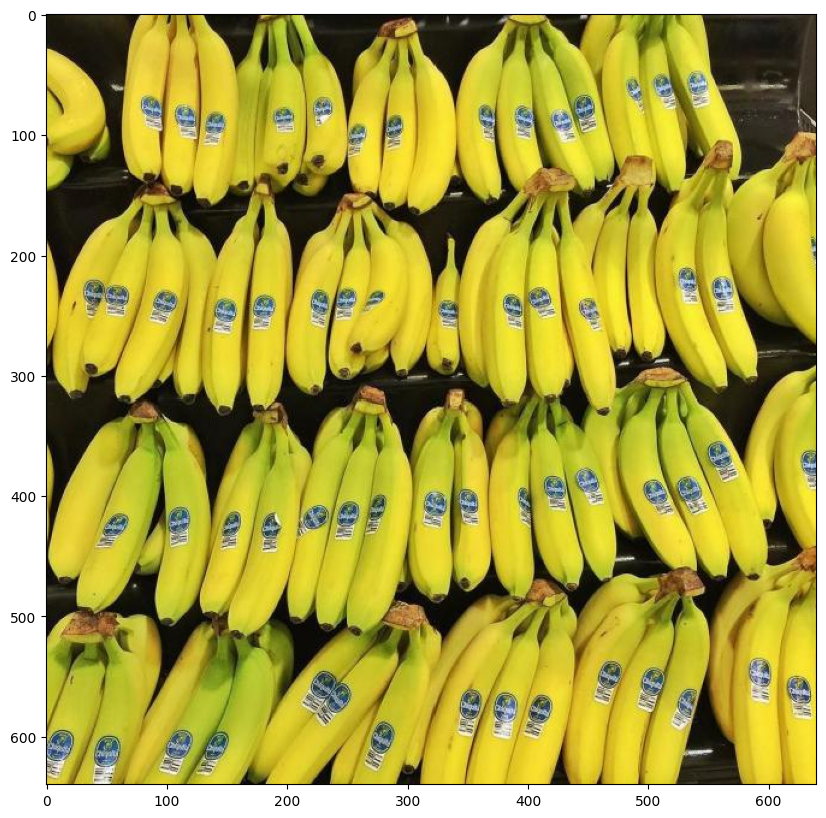

In [33]:
im = cv2.imread("/content/fruit-detection/Fruits-detection/valid/images/023a80af882eba30_jpg.rf.5b5cbadda08d96361527fb5344d7203f.jpg")
outputs = predictor(im)
v = Visualizer(im, metadata=metadata, scale=1., instance_mode =  ColorMode.IMAGE)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)

## **Avaliando modelos treinado no conjunto de teste**

In [35]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model

In [36]:
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[12/14 13:14:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
WARNING [12/14 13:14:54 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/14 13:14:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 13:14:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/14 13:14:54 d2.data.common]: Serializing 914 elements to byte tensors and concatenating them all ...
[12/14 13:14:54 d2.data.common]: Serialized dataset takes 0.42 MiB
[12/14 13:14:54 d2.evaluation.evaluator]: Start inference on 914 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[12/14 13:14:56 d2.evaluation.evaluator]: Inference done 11/914. Dataloading: 0.0013 s/iter. Inference: 0.0804 s/iter. Eval: 0.0004 s/iter. Total: 0.0821 s/iter. ETA=0:01:14
[12/14 13:15:01 d2.evaluation.evaluator]: Inference done 68/914. Dataloading: 0.0041 s/iter. Inference: 0.0826 s/iter. Eval: 0.0005 s/iter. Total: 0.0873 s/iter. ETA=0:01:13
[12/14 13:15:06 d2.evaluation.evaluator]: Inference done 127/914. Dataloading: 0.0033 s/iter. Inference: 0.0824 s/iter. Eval: 0.0004 s/iter. Total: 0.0863 s/iter. ETA=0:01:07
[12/14 13:15:11 d2.evaluation.evaluator]: Inference done 186/914. Dataloading: 0.0029 s/iter. Inference: 0.0825 s/iter. Eval: 0.0004 s/iter. Total: 0.0859 s/iter. ETA=0:01:02
[12/14 13:15:16 d2.evaluation.evaluator]: Inference done 242/914. Dataloading: 0.0034 s/iter. Inference: 0.0830 s/iter. Eval: 0.0004 s/iter. Total: 0.0869 s/iter. ETA=0:00:58
[12/14 13:15:21 d2.evaluation.evaluator]: Inference done 301/914. Dataloading: 0.0031 s/iter. Inference: 0.0831 s/iter. Eval: 0

OrderedDict([('bbox',
              {'AP': 9.625649051306876,
               'AP50': 20.193033188493608,
               'AP75': 6.924264003039447,
               'APs': 2.3128082534814394,
               'APm': 5.458532213181618,
               'APl': 14.561655588465225,
               'AP-Apple': 13.260744586351777,
               'AP-Banana': 13.737745306556779,
               'AP-Grape': 2.7399537547381447,
               'AP-Orange': 25.840578462225693,
               'AP-Pineapple': 1.057416739337397,
               'AP-Watermelon': 1.1174554586314702})])